In [1]:
import pandas as pd
import glob
import json
import re
import emoji
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

Loading file and preprocess

In [2]:
#df = pd.read_csv("tweets.csv")
corpus_data =pd.read_csv("tweets.csv", delimiter=',', encoding='utf-8')
corpus_data =corpus_data[['id', 'author_id','created_at','lang','text',
                          'author.username', 'author.description', 'geo.country', 'geo.full_name',\
                          'geo.coordinates.coordinates']]
corpus_data['lang'].value_counts()
corpus_data=corpus_data[corpus_data.lang=="en"]

corpus_data_RT =pd.read_csv("tweets_v2_30k_followers.csv", delimiter=',', encoding='utf-8')
corpus_data_RT =corpus_data_RT[['id', 'author_id','created_at','lang','text',
                          'author.username', 'author.description', 'geo.country', 'geo.full_name',\
                          'geo.coordinates.coordinates']]
corpus_data_RT['lang'].value_counts()
corpus_data_RT=corpus_data_RT[corpus_data_RT.lang=="en"]

<ipython-input-2-53f63ffd624f>:2: DtypeWarning: Columns (28,29,31,67) have mixed types. Specify dtype option on import or set low_memory=False.
  corpus_data =pd.read_csv("tweets.csv", delimiter=',', encoding='utf-8')
<ipython-input-2-53f63ffd624f>:9: DtypeWarning: Columns (7,11,28,29,31,39,41,42,43,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  corpus_data_RT =pd.read_csv("tweets_v2_30k_followers.csv", delimiter=',', encoding='utf-8')


In [3]:
print(corpus_data.shape)
print(corpus_data_RT.shape)

(151021, 10)
(9187, 10)


In [4]:
# corpus_data = corpus_data.sample(n=9187)
# print(corpus_data.shape)

Filter from corpus_data RT followers

In [5]:
RT_followers = pd.read_csv("follower_us_df_81935.csv", delimiter=',', encoding='utf-8')

In [6]:
corpus_data = corpus_data[~corpus_data['author.username'].isin(RT_followers['name'])]
corpus_data.shape

(150997, 10)

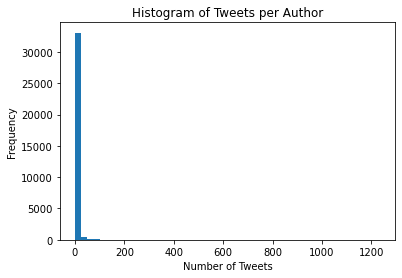

In [7]:
# Group the tweets by author id and count the number of tweets per author
tweet_counts = corpus_data.groupby("author_id").size().reset_index(name="count")

# Plot a histogram of the number of tweets per author
plt.hist(tweet_counts["count"], bins=50)
plt.xlabel("Number of Tweets")
plt.ylabel("Frequency")
plt.title("Histogram of Tweets per Author")
plt.show()

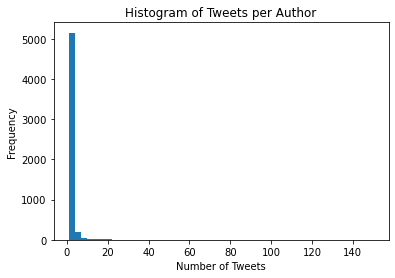

In [8]:
# Group the tweets by author id and count the number of tweets per author
tweet_counts_RT = corpus_data_RT.groupby("author_id").size().reset_index(name="count")

# Plot a histogram of the number of tweets per author
plt.hist(tweet_counts_RT["count"], bins=50)
plt.xlabel("Number of Tweets")
plt.ylabel("Frequency")
plt.title("Histogram of Tweets per Author")
plt.show()

Doesn't seems to be any bot according to the graph above

In [9]:
# tweet_counts = corpus_data.groupby("author.description").size().reset_index(name="count")
# bots = tweet_counts[tweet_counts["count"] > 1000]["author.description"]

In [10]:
#Converting created_at string to Datetime
corpus_data['year'] = pd.DatetimeIndex(corpus_data['created_at']).year
corpus_data['month'] = pd.DatetimeIndex(corpus_data['created_at']).month
corpus_data['day'] = pd.DatetimeIndex(corpus_data['created_at']).day
corpus_data['created_at'] =  pd.to_datetime(corpus_data['created_at'], format="%Y/%m/%d")

#Converting created_at string to Datetime
corpus_data_RT['year'] = pd.DatetimeIndex(corpus_data_RT['created_at']).year
corpus_data_RT['month'] = pd.DatetimeIndex(corpus_data_RT['created_at']).month
corpus_data_RT['day'] = pd.DatetimeIndex(corpus_data_RT['created_at']).day
corpus_data_RT['created_at'] =  pd.to_datetime(corpus_data_RT['created_at'], format="%Y/%m/%d")

In [11]:
#Grabbing tweets a month before and after of 2022-02-14 when Russian invade Ukraine
text_before=corpus_data[(corpus_data['created_at'] < pd.to_datetime('2022/02/14',utc=True))].text
text_after=corpus_data[(corpus_data['created_at'] >= pd.to_datetime('2022/02/14',utc=True))].text
#Check how many tweets I have before and after:
print(len(text_before))
print(len(text_after))

text_before_RT=corpus_data_RT[(corpus_data_RT['created_at'] < pd.to_datetime('2022/02/14',utc=True))].text
text_after_RT=corpus_data_RT[(corpus_data_RT['created_at'] >= pd.to_datetime('2022/02/14',utc=True))].text

9420
141577


<AxesSubplot:xlabel='created_at'>

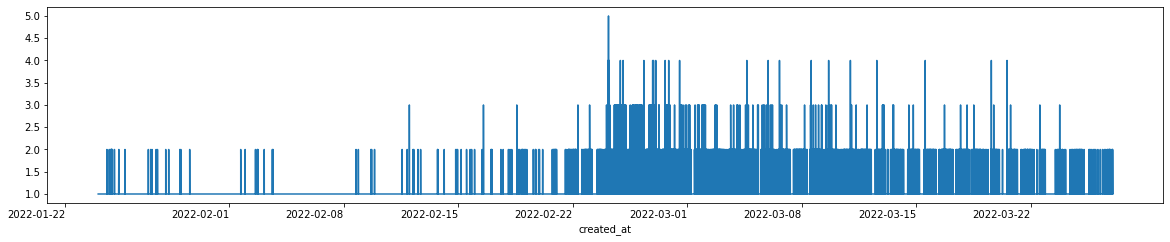

In [12]:
#Plot my original dataframe to confirm this distribution in time:

fig, axs = plt.subplots(figsize=(20, 4))
corpus_data.groupby([corpus_data['created_at']])["text"].count().plot(kind='line', rot=0, ax=axs)

<AxesSubplot:xlabel='created_at'>

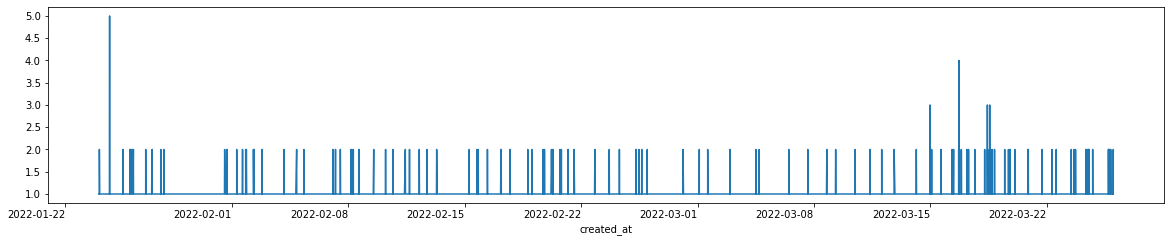

In [13]:
#Plot my original dataframe to confirm this distribution in time:

fig, axs = plt.subplots(figsize=(20, 4))
corpus_data_RT.groupby([corpus_data_RT['created_at']])["text"].count().plot(kind='line', rot=0, ax=axs)

Sentiment Analysis

In [14]:
import nltk
nltk.download("opinion_lexicon")
from nltk.corpus import opinion_lexicon
from tqdm import tqdm

# Load the positive and negative words from the opinion lexicon
pos_vocab = opinion_lexicon.positive()
neg_vocab = opinion_lexicon.negative()


#code breaks without the following because of special characters used in neg_vocab
neg_vocab = [re.sub(r'[^\w\s]', '', word) for word in neg_vocab]

# Initialize two lists to store the count of positive and negative words
Pos_list = []
Neg_list = []
# Compile the regular expression pattern for positive words
pos = re.compile("|".join(r"\b%s\b" % w for w in pos_vocab))
# Compile the regular expression pattern for negative words
neg = re.compile("|".join(r"\b%s\b" % s for s in neg_vocab))




# Loop over each row in the corpus_data dataframe and analyze the positive sentiment
for text in tqdm(corpus_data.text):
    
    
    # Find all the positive words in the text
    wordcount = Counter(re.findall(pos, text.lower()))
    # Add the count of positive words to the Pos_list
    Pos_list.append(sum(wordcount.values()))
    
    # Find all the negative words in the text
    wordcount = Counter(re.findall(neg, text.lower()))
    # Add the count of negative words to the Neg_list
    Neg_list.append(sum(wordcount.values()))

# Add the Pos_list as a new column in the corpus_data dataframe
corpus_data['Pos_count'] = Pos_list
corpus_data['Neg_count'] = Neg_list
corpus_data["count"]=1
corpus_data["tweets"] = corpus_data['count'].groupby([corpus_data['month']]).transform('sum')


Pos_list_RT = []
Neg_list_RT = []
for text in tqdm(corpus_data_RT.text):
    
    
    # Find all the positive words in the text
    wordcount = Counter(re.findall(pos, text.lower()))
    # Add the count of positive words to the Pos_list
    Pos_list_RT.append(sum(wordcount.values()))
    
    # Find all the negative words in the text
    wordcount = Counter(re.findall(neg, text.lower()))
    # Add the count of negative words to the Neg_list
    Neg_list_RT.append(sum(wordcount.values()))

# Add the Pos_list as a new column in the corpus_data dataframe
corpus_data_RT['Pos_count'] = Pos_list_RT
corpus_data_RT['Neg_count'] = Neg_list_RT
corpus_data_RT["count"]=1
corpus_data_RT["tweets"] = corpus_data_RT['count'].groupby([corpus_data_RT['month']]).transform('sum')


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\ghias\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
100%|█████████████████████████████████████████████████████████████████████████████| 9187/9187 [00:13<00:00, 656.34it/s]


Now define a tweet as positive if there are more positive words then negative words in it - and vice versa. Then aggregate at the year/month level by summing. Then divide by the total number of tweets that month.

In [15]:
corpus_data['Pdum']=((corpus_data['Pos_count']-corpus_data['Neg_count'])>0)*1
corpus_data['Ndum']=((corpus_data['Pos_count']-corpus_data['Neg_count'])<0)*1 

corpus_data_RT['Pdum']=((corpus_data_RT['Pos_count']-corpus_data_RT['Neg_count'])>0)*1
corpus_data_RT['Ndum']=((corpus_data_RT['Pos_count']-corpus_data_RT['Neg_count'])<0)*1 

In [16]:
corpus_data['Pos_tweets_total'] = corpus_data['Pdum'].groupby([corpus_data['month']]).transform('sum')
corpus_data['Neg_tweets_total'] = corpus_data['Ndum'].groupby([corpus_data['month']]).transform('sum')

corpus_data_RT['Pos_tweets_total'] = corpus_data_RT['Pdum'].groupby([corpus_data_RT['month']]).transform('sum')
corpus_data_RT['Neg_tweets_total'] = corpus_data_RT['Ndum'].groupby([corpus_data_RT['month']]).transform('sum')

In [17]:
corpus_data["pos_neg_share"] =100*(corpus_data['Pos_tweets_total']-corpus_data['Neg_tweets_total']) /corpus_data["tweets"]
corpus_data_RT["pos_neg_share"] =100*(corpus_data_RT['Pos_tweets_total']-corpus_data_RT['Neg_tweets_total']) /corpus_data_RT["tweets"]


In [18]:
# fig, axs = plt.subplots(figsize=(20, 4))

# corpus_data.groupby([corpus_data['year'], corpus_data['month'], corpus_data['day']])["pos_neg_share"].mean().plot(kind='line', rot=0, ax=axs, color='blue', label='Control')
# corpus_data_RT.groupby([corpus_data['year'], corpus_data_RT['month'], corpus_data_RT['day']])["pos_neg_share"].mean().plot(kind='line', rot=0, ax=axs, color='red', label='Treatment')
# for label in axs.get_xticklabels(which='major'):
#     label.set(rotation=30, horizontalalignment='right')

# plt.xlabel("Day");  # custom x label using matplotlib
# plt.ylabel("Positive minus negative terms per Tweet (in %)")
# axs.legend()

In [19]:
# corpus_data['week_number'] = corpus_data['created_at'].dt.week
# corpus_data_RT['week_number'] = corpus_data_RT['created_at'].dt.week
# fig, axs = plt.subplots(figsize=(20, 4))


# corpus_data.groupby([corpus_data['year'], corpus_data['week_number']])["pos_neg_share"].mean().plot(kind='line', rot=0, ax=axs,color='blue', label='Control')
# corpus_data_RT.groupby([corpus_data['year'], corpus_data_RT['week_number']])["pos_neg_share"].mean().plot(kind='line', rot=0, ax=axs, color='red', label='Treatment')
# for label in axs.get_xticklabels(which='major'):
#     label.set(rotation=30, horizontalalignment='right')

# plt.xlabel("Week");  # custom x label using matplotlib
# plt.ylabel("Positive minus negative terms per Tweet (in %)")
# axs.legend()

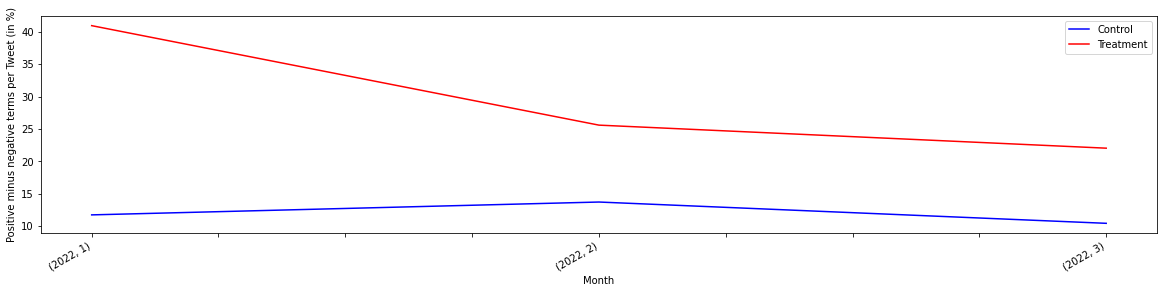

In [20]:
fig, axs = plt.subplots(figsize=(20, 4))

corpus_data.groupby([corpus_data['year'], corpus_data['month']])["pos_neg_share"].mean().plot(kind='line', rot=0, ax=axs,color='blue', label='Control')
corpus_data_RT.groupby([corpus_data_RT['year'], corpus_data_RT['month']])["pos_neg_share"].mean().plot(kind='line', rot=0, ax=axs,color='red', label='Treatment')
for label in axs.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

plt.xlabel("Month");  # custom x label using matplotlib
plt.ylabel("Positive minus negative terms per Tweet (in %)")
axs.legend()

In [40]:
examples_corpus = corpus_data.copy().drop(columns=['id', 'author_id', 'created_at', 'lang', 'author.username',
       'author.description', 'geo.country', 'geo.full_name',
       'geo.coordinates.coordinates', 'year', 'month', 'day', 'count', 'tweets', 'Pdum', 'Ndum', 'Pos_tweets_total',
       'Neg_tweets_total'])
examples_corpus_RT = corpus_data_RT.copy().drop(columns=['id', 'author_id', 'created_at', 'lang', 'author.username',
       'author.description', 'geo.country', 'geo.full_name',
       'geo.coordinates.coordinates', 'year', 'month', 'day', 'count', 'tweets', 'Pdum', 'Ndum', 'Pos_tweets_total',
       'Neg_tweets_total'])

In [49]:
pd.options.display.max_colwidth = None
examples_corpus[examples_corpus['Pos_count'] == 10]

,text,Pos_count,Neg_count,pos_neg_share
6342,"We are at such a pivotal moment in history. If we don’t take strong decisive steps now future of a Europe whole free at peace &amp; prosperous &amp; secure transatlantic community is over. Energy &amp; defense top list. Truth is Russia, China, Iran under these regimes can never be trusted. https://t.co/NIXyV9WYMd",10,0,10.434061
13693,93 i support russia because i like russian history and culture. I support Vladimir putin the russian President because he is a x spy and iam a spy buff. I also support putin because he rebuilt russia and he made russia a mighty military power. I believe in a strong russia. 93s,10,0,10.434061
18575,93 i support russia because i like russian history and culture. I support Vladimir putin the russian President because he is a x spy and ism a spy buff i aldo support putin because he rebuilt russia and he made russia a mighty military power i believe in a strong russia. 93s,10,0,10.434061
19771,"@patriottakes @mtgreenee is a liar. Every video she posts is riddled with misinformation. @Ukraine has been heroically ""not winning"" this war for a month now! Traitors to freedom like MTG will never understand why a Free Ukraine is good for the world. Let's not turn our backs on Freedom!",10,1,10.434061
21691,93 i support russia because i like russian history and culture. I support Vladimir Putin the russian President because he is a x spy and ism a spy buff. I also support putin because he rebuilt russia he made russia a mighty military power. I believe in a strong russia. 93s,10,0,10.434061
25197,93 i support russia because i like russian history and culture. I support putin the Russian President because he is a x spy and ism a spy buff. I also support putin because he rebuilt russia. He made russia a mighty military power. I believe in a strong russia. 93s,10,0,10.434061
31393,93 i support russia because i like russian history and culture. I support Vladimir putin the russian President because he is a x spy and iam a spy buff. I also support putin because he rebuilt russia he made russia a mighty military power. I believe in a strong russia. 93s,10,0,10.434061
37088,93 i support russia because i like russian history and culture. I support Vladimir putin the russian President because he is a x spy and iam a spy buff. I also support putin because he rebuilt russia and he made russia a mighty military power. I believe in a strong russia. 93s,10,0,10.434061
44035,"@GOP @GOPLeader @LeaderMcConnell \nJust remember the leader of the GOP said Putin was a ""Genius"" and ""I'd say that's pretty smart. He's taking over a country -- really a vast, vast location, a great piece of land with a lot of people, and just walking right in.""\n#Ukraine https://t.co/L43jkIWnxq",10,0,10.434061
50774,"@onlycoinuneed @JackPosobiec Well, President Trump never called Putin a genius, he said he is smart and Putin is smart, devil way but he is smart, all this stupid talk about Russia slowing down or getting weaker is a bull 💩, everything that Putin does is a strategy, is a tactic to destroy and weaken Ukraine",10,6,10.434061


In [46]:
pd.options.display.max_colwidth = None
examples_corpus_RT[examples_corpus_RT['Pos_count'] > 4]

,text,Pos_count,Neg_count,pos_neg_share
8467,We just announced the winner and runner ups of the R. Edward Freeman Journal of Business Ethics Philosophy in Practice Best Paper Award 2021! Congratulations to all authors! \n\nThe full list of winners and runner ups through the years can be found here: https://t.co/N3lCDC6qa5,5,0,25.585399
8468,We just announced the winner and runner ups of the R. Edward Freeman Journal of Business Ethics Philosophy in Practice Best Paper Award 2021! Congratulations to all authors! \n\nThe full list of winners and runner ups through the years can be found here: https://t.co/N3lCDC6qa5,5,0,25.585399
8469,We just announced the winner and runner ups of the R. Edward Freeman Journal of Business Ethics Philosophy in Practice Best Paper Award 2021! Congratulations to all authors! \n\nThe full list of winners and runner ups through the years can be found here: https://t.co/N3lCDC6qa5,5,0,25.585399
8470,We just announced the winner and runner ups of the R. Edward Freeman Journal of Business Ethics Philosophy in Practice Best Paper Award 2021! Congratulations to all authors! \n\nThe full list of winners and runner ups through the years can be found here: https://t.co/N3lCDC6qa5,5,0,25.585399
9741,"@blackhellound https://t.co/AN6DyRrX5H\nThis and the series that go with it, absolute gold. \nhttps://t.co/MI38GKReNN\nSo much angst but it's worth it. \nhttps://t.co/hCszGnX3up\nIdk what to say abt this one but I love it\nhttps://t.co/HxBDJzoWVU\nBanter and hurt/comfort. 10/10 love it",5,1,22.029851
...,...,...,...,...
35567,"Enjoy life with Power G! Cut the wires and plug-in a peace of mind with PowerG, the leading wireless security technology for today's homes and businesses.\n\nBlog Post about Power G - https://t.co/1XsmzKbW5O\n\nQuestions? Feel free to call us at 801-770-2806 https://t.co/AoyKkBvQrS",5,0,25.585399
35653,"A fabulous full English breakfast is provided at Rye Hill using the finest, locally sourced ingredients. The perfect start to a busy day of exploring Northumberland. \nhttps://t.co/fMFS61JRCz\n#Slaley #Hexham #Northumberland #Staycation #BandB #GuestHouse #FullEnglish #Exploring https://t.co/57i51me3Su",5,0,25.585399
35891,"CONGRATULATIONS @haesooyahh_2806 for winning our GA. Kindly, send us a dm on how to claim your prize 🎊🎉 https://t.co/3ffrxHub6u https://t.co/aGlHWoLkKJ",5,0,25.585399
36342,"Happy birthday to MOA's love, KANG TAEHYUN\nThank you for being born and becoming a part of TXT\nStay healthy and live a happy life💞\n\n#사랑을_모아_사랑둥이_태현이에게\n#OurGoldenVoiceTaehyun\n#TAEHYUN @TXT_members",6,0,25.585399


In [31]:
corpus_data.columns

Index(['id', 'author_id', 'created_at', 'lang', 'text', 'author.username',
       'author.description', 'geo.country', 'geo.full_name',
       'geo.coordinates.coordinates', 'year', 'month', 'day', 'Pos_count',
       'Neg_count', 'count', 'tweets', 'Pdum', 'Ndum', 'Pos_tweets_total',
       'Neg_tweets_total', 'pos_neg_share'],
      dtype='object')

In [21]:
corpus_data.to_csv("Corpus_data_final.csv", index = False)
corpus_data_RT.to_csv("Corpus_data_RT_final.csv", index = False)
corpus_data.head()

,id,author_id,created_at,lang,text,author.username,author.description,geo.country,geo.full_name,geo.coordinates.coordinates,...,day,Pos_count,Neg_count,count,tweets,Pdum,Ndum,Pos_tweets_total,Neg_tweets_total,pos_neg_share
0,1507869978195898372,1374747423709532165,2022-03-26 23:59:52+00:00,en,@dwatts26726 @For_HongKong @JackPosobiec Zelen...,HeightsTiger,LSU Alum & Texas Ex. Oil & Gas Consultant. Tru...,Estados Unidos,"Houston, TX",NaN,...,26,4,0,1,84320,1,0,32460,23662,10.434061
1,1507869783366250498,2906315945,2022-03-26 23:59:05+00:00,en,Anybody else feel like there is a non-zero % c...,bmsbreaux,🚀HTX/NOLA⚜️ | 👨🏼‍💻 Chief Problem Solver | 🧠 Mi...,Estados Unidos,"Houston, TX",NaN,...,26,4,0,1,84320,1,0,32460,23662,10.434061
2,1507869375340101644,1487548160146874372,2022-03-26 23:57:28+00:00,en,@omriceren Did Biden ask Ukraine for a favor? ...,Thehighroadpdf,NaN,Estados Unidos,"San Antonio, TX",NaN,...,26,3,1,1,84320,1,0,32460,23662,10.434061
3,1507868479944286210,21526235,2022-03-26 23:53:55+00:00,en,@KremlinRussia_E Hands off Ukraine.#Zelenskyy ...,AlissaDCook,Account Executive,Estados Unidos,"Roswell, GA",NaN,...,26,0,0,1,84320,0,0,32460,23662,10.434061
4,1507867667167907845,624323978,2022-03-26 23:50:41+00:00,en,@Gabby82gs @mevvybear Putin knew as soon as he...,conenor,NaN,Estados Unidos,"Cincinnati, OH",NaN,...,26,3,1,1,84320,1,0,32460,23662,10.434061


The difference-in-difference estimate is a method used to estimate the causal effect of an intervention or treatment on an outcome variable, which in this case would be the effect of Russian invasion in Ukraine on Tweeter users. It involves comparing the difference in the outcome variable between two groups, the treatment and the control; in this case our treatment group is poeple who follows Russia Today in the USA and our control group is random tweeter users from USA. The idea behind it is that the effect of this Russian official account can be isolated by comparing with people that doesn't follow this type of accounts. If the treatment had a positive effect, we would expect to see a greater increase or at less negative in the sentiment for the treated group compared to the control group.

A base fixed effects regression equation for the difference-in-difference estimate of the effect on the sentiment would be: 

$\text{Sentiment}_{it} = \beta_0 + \beta_1 * \text{RT} + \beta_2 * \text{Time} + \beta_3 * \text{RT} * \text{Time} + \epsilon_{it}$

Where:

- $\text{Sentiment}_{it}$ is the dependent variable, representing the sentiment in tweeter users.
- $\text{RT}$ is a dummy variable indicating whether tweeter user follows or not Russia Today.
- $\text{Time}$ is a dummy variable indicating the time period, with two levels: before Russia invade Ukraine (0) and after (1).
- $\beta_0$ is the first coefficient to be estimated by the regression representing the intercept.
- $\beta_1$ is the coefficient of the treatment dummy variable, which in this case represents the effect of following RT.
- $\beta_2$ is the coefficient of the post dummy variable, which in this case represents the effect of time before and after the invasion.
- $\beta_3$ is the coefficient of the interaction term between the two dummy variables, RT and Time. 
- $\text{RT} * \text{Time}$ is the interaction term between RT and Time, capturing the difference-in-difference estimate of the effect of the invasion to Ukraine on the sentiment of Tweeter users.
- $\epsilon_{it}$ is the error term representing any other factors affecting the sentiment on Twitter Users not included in the model.


In [21]:
corpus_data.columns

Index(['id', 'author_id', 'created_at', 'lang', 'text', 'author.username',
       'author.description', 'geo.country', 'geo.full_name',
       'geo.coordinates.coordinates', 'year', 'month', 'day', 'Pos_count',
       'Neg_count', 'count', 'tweets', 'Pdum', 'Ndum', 'Pos_tweets_total',
       'Neg_tweets_total', 'pos_neg_share', 'week_number'],
      dtype='object')

In [22]:
corpus_data_RT.columns

Index(['id', 'author_id', 'created_at', 'lang', 'text', 'author.username',
       'author.description', 'geo.country', 'geo.full_name',
       'geo.coordinates.coordinates', 'year', 'month', 'day', 'Pos_count',
       'Neg_count', 'count', 'tweets', 'Pdum', 'Ndum', 'Pos_tweets_total',
       'Neg_tweets_total', 'pos_neg_share', 'week_number'],
      dtype='object')

In [23]:
diff_df = corpus_data.drop(columns=['id', 'author_id', 'lang', 'text', 'author.username',
       'author.description', 'geo.country', 'geo.full_name',
       'geo.coordinates.coordinates', 'Pos_count',
       'Neg_count', 'count', 'tweets', 'Pdum', 'Ndum', 'Pos_tweets_total',
       'Neg_tweets_total','week_number'])
diff_df['RT'] = 0 

In [24]:
corpus_data_RT.drop(columns=['id', 'author_id', 'lang', 'text', 'author.username',
       'author.description', 'geo.country', 'geo.full_name',
       'geo.coordinates.coordinates', 'Pos_count',
       'Neg_count', 'count', 'tweets', 'Pdum', 'Ndum', 'Pos_tweets_total',
       'Neg_tweets_total', 'week_number'], inplace=True)
corpus_data_RT['RT'] = 1

In [25]:
diff_df = pd.concat([diff_df, corpus_data_RT])
diff_df

,created_at,year,month,day,pos_neg_share,RT
0,2022-03-26 23:59:52+00:00,2022,3,26,100.0,0
1,2022-03-26 23:59:05+00:00,2022,3,26,100.0,0
2,2022-03-26 23:57:28+00:00,2022,3,26,100.0,0
3,2022-03-26 23:53:55+00:00,2022,3,26,0.0,0
4,2022-03-26 23:50:41+00:00,2022,3,26,100.0,0
...,...,...,...,...,...,...
38607,2022-02-01 08:21:27+00:00,2022,2,1,100.0,1
38608,2022-02-01 06:55:05+00:00,2022,2,1,100.0,1
38609,2022-01-29 18:39:36+00:00,2022,1,29,100.0,1
38610,2022-01-24 14:08:23+00:00,2022,1,24,0.0,1


In [26]:
corpus_data

,id,author_id,created_at,lang,text,author.username,author.description,geo.country,geo.full_name,geo.coordinates.coordinates,...,Pos_count,Neg_count,count,tweets,Pdum,Ndum,Pos_tweets_total,Neg_tweets_total,pos_neg_share,week_number
0,1507869978195898372,1374747423709532165,2022-03-26 23:59:52+00:00,en,@dwatts26726 @For_HongKong @JackPosobiec Zelen...,HeightsTiger,LSU Alum & Texas Ex. Oil & Gas Consultant. Tru...,Estados Unidos,"Houston, TX",NaN,...,4,0,1,1,1,0,1,0,100.0,12
1,1507869783366250498,2906315945,2022-03-26 23:59:05+00:00,en,Anybody else feel like there is a non-zero % c...,bmsbreaux,🚀HTX/NOLA⚜️ | 👨🏼‍💻 Chief Problem Solver | 🧠 Mi...,Estados Unidos,"Houston, TX",NaN,...,4,0,1,1,1,0,1,0,100.0,12
2,1507869375340101644,1487548160146874372,2022-03-26 23:57:28+00:00,en,@omriceren Did Biden ask Ukraine for a favor? ...,Thehighroadpdf,NaN,Estados Unidos,"San Antonio, TX",NaN,...,3,1,1,1,1,0,1,0,100.0,12
3,1507868479944286210,21526235,2022-03-26 23:53:55+00:00,en,@KremlinRussia_E Hands off Ukraine.#Zelenskyy ...,AlissaDCook,Account Executive,Estados Unidos,"Roswell, GA",NaN,...,0,0,1,1,0,0,0,0,0.0,12
4,1507867667167907845,624323978,2022-03-26 23:50:41+00:00,en,@Gabby82gs @mevvybear Putin knew as soon as he...,conenor,NaN,Estados Unidos,"Cincinnati, OH",NaN,...,3,1,1,1,1,0,1,0,100.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151096,1485403397888958475,1467621,2022-01-24 00:05:42+00:00,en,Russia’s gold &amp; foreign currency reserves ...,MissTrade,36 yr Full-time Equities/Futures Trader. Music...,Estados Unidos,"Bend, OR",NaN,...,2,1,1,1,1,0,1,0,100.0,4
151097,1485402867120889859,779776654856089600,2022-01-24 00:03:35+00:00,en,"Though unexpected, this is very good news. Det...",USCentrist,21 | Nixon Democrat | Geopolitics and FP | WW2...,Estados Unidos,"Cambridge, MA",NaN,...,4,4,1,1,0,0,0,0,0.0,4
151098,1485402254874234881,113784225,2022-01-24 00:01:09+00:00,en,@artiomboy This is BREAKING NEWS! US Starting...,Hairyitalian4u,NaN,Estados Unidos,"Fort Myers, FL",NaN,...,5,4,1,1,1,0,1,0,100.0,4
151099,1485402197940748293,972000373,2022-01-24 00:00:56+00:00,en,Breaking non-sports news: The U.S. State Depar...,PaulRooby,Look good feel good play good. One of 19 NBA s...,Estados Unidos,"Ankeny, IA",NaN,...,1,1,1,1,0,0,0,0,0.0,4


0         32460
1         32460
2         32460
3         32460
4         32460
          ...  
151096     1566
151097     1566
151098     1566
151099     1566
151100     1566
Name: Pdum, Length: 150997, dtype: int32